# Developing "Momentum" Trading Strategy
* Many differnt takes on this strategy
* Sometimes referred to as trend following
* Whatever you do and call it, you first need to research potential trading signals

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

### 1. Download data: 
* Many services for this, some paid some free 
* Yahoo Finance API
* Typically trading "systems" involve a number of securities
* For this demonstration we are just going to look at GLD --> the gold ETF

In [9]:
gld = pdr.get_data_yahoo('ETH-USD')
day = np.arange(1, len(gld) + 1)
gld['day'] = day
gld.drop(columns=['Adj Close', 'Volume'], inplace = True)
gld = gld[['day', 'Open', 'High', 'Low', 'Close']]
gld.head()

,day,Open,High,Low,Close
Date,,,,,
2016-12-08,1,8.38350,8.86133,8.23051,8.23051
2016-12-09,2,8.16814,8.67409,8.05433,8.44601
2016-12-10,3,8.43837,8.52841,8.01677,8.12516
2016-12-11,4,8.12641,8.26856,8.10299,8.19362
2016-12-12,5,8.19236,8.60633,8.16508,8.52221


In [4]:
gld.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1822 entries, 2016-12-08 to 2021-12-07
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     1822 non-null   int32  
 1   Open    1822 non-null   float64
 2   High    1822 non-null   float64
 3   Low     1822 non-null   float64
 4   Close   1822 non-null   float64
dtypes: float64(4), int32(1)
memory usage: 78.3 KB


### 2. Add data/transform data
* calculate signal based on some price or statistical action
* we are going to try a moving average crossover to generate signals
* for this strategy we will always by "in" a trade, either long or short
* we are modeling; this means real life variation should be expected

#### Add moving averages to the data frame

In [11]:
gld['9-day'] = gld['Close'].rolling(9).mean().shift()
gld['21-day'] = gld['Close'].rolling(21).mean().shift()
gld[19:25]

,day,Open,High,Low,Close,9-day,21-day
Date,,,,,,,
2016-12-27,20,7.27637,7.32258,7.09047,7.17082,7.505519,NaN
2016-12-28,21,7.14895,7.62406,7.08225,7.52011,7.428352,NaN
2016-12-29,22,7.53913,8.52741,7.53913,8.28416,7.414607,7.809974
2016-12-30,23,8.28988,8.46609,8.05468,8.15998,7.483953,7.812529
2016-12-31,24,8.15115,8.15856,7.90938,7.96910,7.511240,7.798909
2017-01-01,25,7.98231,8.47123,7.98231,8.17257,7.553918,7.791477


#### Add "signal" column  

In [12]:
gld['signal'] = np.where(gld['9-day'] > gld['21-day'], 1, 0)
#gld['signal'] = np.where(gld['9-day'] < gld['21-day'], -1, gld['signal'])
gld.dropna(inplace=True)
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal
Date,,,,,,,,
2016-12-29,22,7.53913,8.52741,7.53913,8.28416,7.414607,7.809974,0
2016-12-30,23,8.28988,8.46609,8.05468,8.15998,7.483953,7.812529,0
2016-12-31,24,8.15115,8.15856,7.90938,7.96910,7.511240,7.798909,0
2017-01-01,25,7.98231,8.47123,7.98231,8.17257,7.553918,7.791477,0
2017-01-02,26,8.17087,8.43633,8.05441,8.37851,7.665742,7.790475,0


#### Calculate Instantaneous returns/system returns

In [19]:
gld['return'] = np.log(gld['Close']).diff()
gld['system_return'] = gld['signal'] * gld['return']
gld['entry'] = gld.signal.diff()
gld.dropna(inplace=True)
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal,return,system_return,entry
Date,,,,,,,,,,,
2016-12-30,23,8.28988,8.46609,8.05468,8.15998,7.483953,7.812529,0,-0.015104,-0.000000,0.0
2016-12-31,24,8.15115,8.15856,7.90938,7.96910,7.511240,7.798909,0,-0.023670,-0.000000,0.0
2017-01-01,25,7.98231,8.47123,7.98231,8.17257,7.553918,7.791477,0,0.025212,0.000000,0.0
2017-01-02,26,8.17087,8.43633,8.05441,8.37851,7.665742,7.790475,0,0.024887,0.000000,0.0
2017-01-03,27,8.37458,9.99680,8.31717,9.72525,7.789380,7.783632,1,0.149055,0.149055,1.0


#### Plot trades on time series

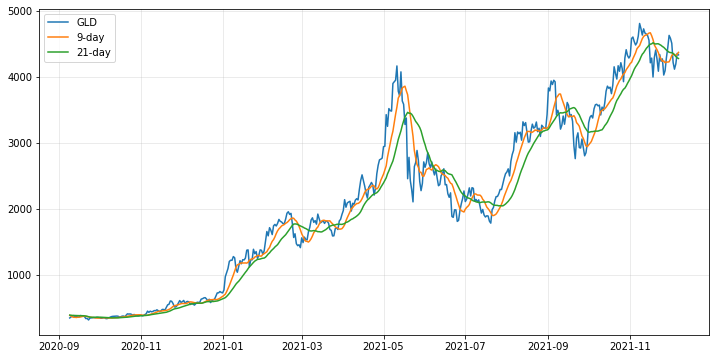

In [20]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[-452:]['Close'], label = 'GLD')
plt.plot(gld.iloc[-452:]['9-day'], label = '9-day')
plt.plot(gld.iloc[-452:]['21-day'], label = '21-day')
plt.plot(gld[-452:].loc[gld.entry == 2].index, gld[-452:]['9-day'][gld.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-452:].loc[gld.entry == -2].index, gld[-452:]['21-day'][gld.entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

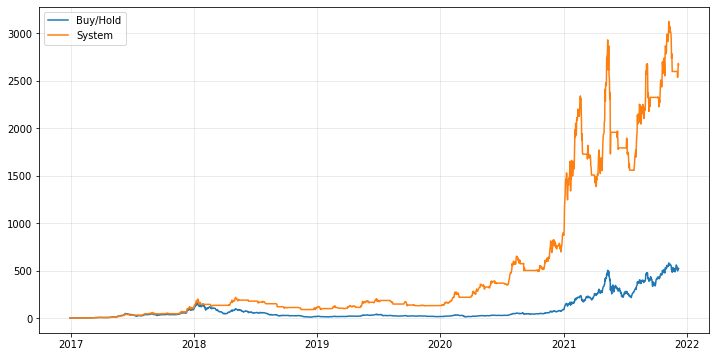

In [21]:
plt.plot(np.exp(gld['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

In [22]:
np.exp(gld['return']).cumprod()[-1] -1

522.4050729568677

In [23]:
np.exp(gld['system_return']).cumprod()[-1] -1

2668.7438305266787